This notebook contains training code for recognising text from images.  

In [0]:
# Import all libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split

from pathlib import Path
from skimage import io, transform
from PIL import Image
import copy,os,sys
import random
import math
import pickle
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Download the dataset and extract into Google drive to access with colab.

In [0]:
!wget https://www.robots.ox.ac.uk/~vgg/data/text/mjsynth.tar.gz
!tar -zxf '/content/mjsynth.tar.gz'
!mkdir '/content/drive/My Drive/Scene text recognition/data'
!cp -r /content/mnt/ramdisk/max/90kDICT32px/[1]* '/content/drive/My Drive/Scene text recognition/data'

--2019-07-01 08:46:03--  https://www.robots.ox.ac.uk/~vgg/data/text/mjsynth.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10678411583 (9.9G) [application/x-gzip]
Saving to: ‘mjsynth.tar.gz’

mjsynth.tar.gz      100%[===================>]   9.94G  11.5MB/s    in 14m 55s 

2019-07-01 09:01:00 (11.4 MB/s) - ‘mjsynth.tar.gz’ saved [10678411583/10678411583]



In [0]:
# Move the annotation file to Google drive
!cp '/content/mnt/ramdisk/max/90kDICT32px/annotation.txt' '/content/drive/My Drive/Scene text recognition/annotation.txt'

In [0]:
!tail '/content/mnt/ramdisk/max/90kDICT32px/annotation.txt'

./1/1/10_besots_7149.jpg 7149
./1/1/9_Sensibly_69429.jpg 69429
./1/1/8_Sandra_67698.jpg 67698
./1/1/7_Bombastic_8610.jpg 8610
./1/1/6_embracing_25311.jpg 25311
./1/1/5_minion_48634.jpg 48634
./1/1/4_underbellies_82078.jpg 82078
./1/1/3_JERKIER_41423.jpg 41423
./1/1/2_Senoritas_69404.jpg 69404
./1/1/1_pontifically_58805.jpg 58805


In [0]:
# Get all letters, digits and punctutation from the string class
labels=string.punctuation+string.ascii_letters+string.digits
labels=list(labels)+['<sos>','<eos>']

label2idx={val:i for i,val in enumerate(labels)}
idx2label={i:val for i,val in enumerate(labels)}
vocab_size=len(label2idx)

In [0]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [0]:
def normalize(x,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    mean=torch.tensor(mean)
    std=torch.tensor(std)
    return (x-mean)/std
    
def denormalize(x,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    mean=torch.tensor(mean)
    std=torch.tensor(std)
    return x*std+mean
    
# changes dim of x from (w,h,3)->(1,3,w,h) to easily pass through model
def img2passable(x):
    x=x.permute((2,0,1))
    x=x.unsqueeze(0)
    return x

# inverse of img_to_passable
# converts (1,3,w,h) to (w,h,3)
def passable2img(x):
    x=x.squeeze(0)
    x=x.permute((1,2,0))
    return x

# x is list of labels and output is list of indices
def labels2idx(x):
    return [label2idx[i.item()] for i in x]

def idx2labels(x):
    return [idx2label[i.item()] for i in x]

# x is list of indices
# returns string of text
def get_label(x):
    return ''.join(idx2labels(x)[:-1])  # Removes <eos>

In [0]:
# Make all models

# Create residual block
class unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(unit,self).__init__()
        
        self.BN1=nn.BatchNorm2d(in_channels)
        self.BN2=nn.BatchNorm2d(out_channels)
        self.conv1x1=nn.Conv2d(in_channels, out_channels, 1)
        self.conv3x3=nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
    def forward(self,x):
        y=self.conv1x1(F.relu(self.BN1(x)))
        y=self.conv3x3(F.relu(self.BN2(y)))
        # y=self.conv1x1(F.relu(x))
        # y=self.conv3x3(F.relu(y))
        # x=torch.cat((x,y),dim=1)
        x=x+y
        return x
    
# Create encoder CNN
class Encoder_CNN(nn.Module):
    def __init__(self):
        super(Encoder_CNN,self).__init__()
        self.b0=nn.Conv2d(3,32,3,padding=1)

        self.conv01=nn.Conv2d(32,32,3,stride=2,padding=1)
        self.b1=nn.Sequential(unit(32,32),unit(32,32),unit(32,32))
        
        self.conv12=nn.Conv2d(32,64,3,stride=2,padding=1)
        self.b2=nn.Sequential(unit(64,64),unit(64,64),unit(64,64),unit(64,64))
                
        self.conv23=nn.Conv2d(64,128,3,stride=(2,1),padding=1)
        self.b3=nn.Sequential(unit(128,128),unit(128,128),unit(128,128),unit(128,128),unit(128,128),unit(128,128))
        
        self.conv34=nn.Conv2d(128,256,3,stride=(2,1),padding=1)
        self.b4=nn.Sequential(unit(256,256),unit(256,256),unit(256,256),unit(256,256),unit(256,256),unit(256,256))
        
        self.conv45=nn.Conv2d(256,512,3,stride=(2,1),padding=1)
        self.b5=nn.Sequential(unit(512,512),unit(512,512),unit(512,512))
        
    def forward(self,x):
        x=self.b0(x)
        x=self.b1(self.conv01(F.relu(x)))
        x=self.b2(self.conv12(F.relu(x)))
        x=self.b3(self.conv23(F.relu(x)))
        x=self.b4(self.conv34(F.relu(x)))
        x=self.b5(self.conv45(F.relu(x)))
        return x
        
# Create decoder LSTM
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        embed_size=round(vocab_size**0.25)

        self.lstm_cell=nn.LSTMCell(embed_size+512,512) 
        self.embeddings=nn.Embedding(vocab_size,embed_size)
        self.ench=nn.Linear(512,256)   # V in paper
        self.dech=nn.Linear(512,256)   # W in paper
        self.w=nn.Linear(256,1,bias=False)
        self.lin1=nn.Linear(512,256)
        self.linout=nn.Linear(256,vocab_size)
            
            
    # enc_h is all encoder hidden states (N,seq_len,512)
    # h is last hidden state of encoder for all layers (num_layers*directions,N,256)
    # c is last cell state of encoder for all layers (num_layers*directions,N,256)
    def forward(self,enc_h,h,c,labels,lengths):
        h=h[2:].transpose(0,1).contiguous()   # take last layer only
        h=h.view(h.size(0),-1)    # (N,512)
        c=c[2:].transpose(0,1).contiguous()
        c=c.view(c.size(0),-1)    # (N,512)
        
        max_length=max(lengths).item()
        batch_size=len(labels)
        
        inp=torch.ones((batch_size),dtype=torch.long,device=device)*label2idx['<sos>']  # input at t=1 is <sos> 
        out_list,alpha_list=[],[]
        for t in range(max_length):
            inp=self.embeddings(inp)
            g,alpha=self.step(enc_h,h)
            h,c=self.lstm_cell(torch.cat((inp,g),dim=1),(h,c))
            out=self.linout(F.relu(self.lin1(h)))
            
            inp=labels[:,t]                       # previous output is current input
            out_list.append(out.unsqueeze(1))     # adding time dimension
            alpha_list.append(alpha.unsqueeze(1)) # adding time dimension
            
        out_list=torch.cat(out_list,dim=1)   
        alpha_list=torch.cat(alpha_list,dim=1)   
        # out_list=F.log_softmax(out_list,dim=2)
        return out_list,alpha_list
    
    # generates glimpse vector between decoder's prev hidden state and all encoder hidden states for a single t
    def step(self,enc_h,h):
        h=h.unsqueeze(1)
        e=self.w(torch.tanh(self.dech(h)+self.ench(enc_h)))
        e=e.squeeze(-1)
        alpha=torch.softmax(e,dim=1)
        g=torch.einsum('bi,bij->bj',alpha,enc_h)
        return g, alpha
        
# Combines both the CNN encoder and LSTM decoder to produce final output 
class Recognition(nn.Module):
    def __init__(self):
        super(Recognition,self).__init__()
        
        self.enc_cnn=Encoder_CNN()
        self.enc_rnn=nn.LSTM(512,256,num_layers=2,batch_first=True,bidirectional=True)
#         self.lin1=nn.Linear(512,256)
        self.decoder1=Decoder()
        self.decoder2=Decoder()    
        
    def forward(self,x,flabels,rlabels,lengths):
        x=self.enc_cnn(x)
        x=x.permute((0,3,1,2)).squeeze(-1)   # reshapes to (batch_size,seq_length,feature_length)
        out,(h,c) =self.enc_rnn(x)
        fout_list, falpha_list=self.decoder1(out,h,c,flabels,lengths)      # forward decoder
        rout_list, ralpha_list=self.decoder2(out,h,c,rlabels,lengths)      # backward decoder
#         mask=self.create_mask(lengths)
#         output_list[~mask]=0  #np.float('-inf')
#         out=F.relu(self.lin1(out))     # try batch norm here 
        return fout_list, rout_list, falpha_list
    
    def create_mask(self,lengths):
        mask=torch.arange(max(lengths)).expand((len(lengths),-1)).to(device)
        mask=(mask<lengths.unsqueeze(-1))
        return mask

In [0]:
def preprocess(I,model):
    # One time cost only 
    x=model.enc_cnn(img2passable(I))
    x=x.permute((0,3,1,2)).squeeze(-1)    # reshapes to (batch_size,seq_length,feature_length)
    enc_h,(h,c) = model.enc_rnn(x)
    h=h[2:].transpose(0,1).contiguous()   # take last layer only
    h=h.view(h.size(0),-1)    # (1,512)
    c=c[2:].transpose(0,1).contiguous()
    c=c.view(c.size(0),-1)    # (1,512)
    inp=torch.ones((1),dtype=torch.long, device=device)*label2idx['<sos>']  # input at t=1 is <sos> 
    return inp,h,c


def decode(model,inp,h,c):
    inp=model.decoder1.embeddings(inp)
    g,_=model.decoder1.step(enc_h,h)
    h,c=model.decoder1.lstm_cell(torch.cat((inp,g),dim=1),(h,c))
    out=model.decoder1.linout(F.relu(model.decoder1.lin1(h)))
    return out, h, c

# Decodes the given sequence logits
# pred=(seq_len,vocab_size), k=beam width
# if k=1 => greedy 
# if 1<k<t => beam search  
# if k=t => brute-force 
def decoder(pred,k=1):    
    if k==1:                   # Greedy Search   # TODO: make it for input as image only
        for t in range(pred.size(0)):
            i=torch.argmax(pred[t])
            if idx2label[i.item()]!='<eos>':
                print(idx2label[i.item()],end='')

    elif k!=pred.size(0):      # Beam Search TODO
        inp,h,c=preprocess(I,model)
        out,h,c=decode(model,inp,h,c)
        val,ind=torch.topk(out,k,largest=True)
        hist=[]
        labels=idx2labels(ind)
        for i in range(len(labels)):
            hist.append((labels[i],val[i],h,c))  # label,prob,h,c

## Start TRAINING

Change the image and model paths below

In [0]:
train_transforms=transforms.Compose([
        transforms.Resize((32,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

valid_transforms=transforms.Compose([
        transforms.Resize((32,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

def my_collate(batch):
    data=[i[0].unsqueeze(0) for i in batch]
    flabels=[i[1] for i in batch]
    rlabels=[i[2] for i in batch]
    lengths=[i[3] for i in batch]
    flabels=torch.LongTensor([i+[label2idx['<eos>']]*(max(lengths)-len(i)) for i in flabels])   # pad with <eos> tokens
    rlabels=torch.LongTensor([i+[label2idx['<sos>']]*(max(lengths)-len(i)) for i in rlabels])   # pad with <sos> tokens
    return torch.cat(data,dim=0), flabels, rlabels, torch.LongTensor(lengths)
    
class dataset(datasets.ImageFolder):
    def __getitem__(self, i):
        original_tuple = super(dataset, self).__getitem__(i)
        path = self.imgs[i][0]
        label=path.split('_')[1]
        flabel=list(label)+['<eos>']          # forward output labels
        rlabel=list(label)[::-1]+['<sos>']    # reverse output labels
        flabel=[label2idx[i] for i in flabel]
        rlabel=[label2idx[i] for i in rlabel]
        return original_tuple[0],flabel,rlabel,len(flabel)


IMG_PATH='/content/drive/My Drive/Scene text recognition/data/'
train_set=dataset(IMG_PATH, train_transforms)
valid_set=dataset(IMG_PATH, valid_transforms)
# test_set=dataset('/content/images/',test_df,valid_transforms,istest=True)

batch_size=64
train_loader=DataLoader(train_set, batch_size=batch_size, shuffle=True,collate_fn=my_collate,pin_memory=True,num_workers=8)
valid_loader=DataLoader(valid_set, batch_size=batch_size)
# test_loader=DataLoader(test_set, batch_size=8)

In [0]:
# Load the model, optimiser and the loss function
model=Recognition().to(device)
optimiser=optim.Adam(model.parameters(),lr=1e-4)
lossfn=nn.CrossEntropyLoss()

def calc_loss(pred,labels):
    loss=0
    for i in range(pred.size(1)):     # seq_length dim
        loss+=lossfn(pred[:,i],labels[:,i])
    return loss

In [0]:
# TRAIN THE MODEL
epochs=50
loss_h=[]

for e in range(epoch,epochs):
    tot_loss=0
    for batch,flabels,rlabels,lengths in train_loader:
        batch=batch.to(device)
        flabels=flabels.to(device)
        rlabels=rlabels.to(device)
        lengths=lengths.to(device)
        optimiser.zero_grad()

        fpred,rpred,alphas=model(batch,flabels,rlabels,lengths)   
        loss=0.5*(calc_loss(fpred,flabels)+calc_loss(rpred,rlabels))
        loss.backward()
        optimiser.step()
        tot_loss+=loss.item()
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimiser_state_dict': optimiser.state_dict(),
            'loss_h': loss_h,
            }, '/content/drive/My Drive/Scene text recognition/text_recognition_revdecoder_epoch{}.pth'.format(e))
    
    tot_loss/=len(train_loader)
    loss_h.append(tot_loss)
    print('Loss in epoch {} = {}'.format(e, tot_loss))

TRaining starTeD
loss in epoch 0 = 29.65858753876795

loss in epoch 1 = 24.384523937569867

loss in epoch 2 = 21.026255617982287

loss in epoch 3 = 13.813699123260117

loss in epoch 4 = 7.393409310928237

loss in epoch 5 = 4.892732756441384

loss in epoch 6 = 3.809656375640105

loss in epoch 7 = 3.1411799066603767

loss in epoch 8 = 2.7166296441809266

loss in epoch 9 = 2.383363974399224

loss in epoch 10 = 2.1281862535531166

loss in epoch 11 = 1.9076894444694197

loss in epoch 12 = 1.7328410596628314

loss in epoch 13 = 1.5932954653562477

loss in epoch 14 = 1.4662350916888431

loss in epoch 15 = 1.335463422183373

loss in epoch 16 = 1.2656685027645513

loss in epoch 17 = 1.1592571245216572

loss in epoch 18 = 1.0766785509065524

loss in epoch 19 = 0.9982552102587557

loss in epoch 20 = 0.9267449543869145

loss in epoch 21 = 0.8639588951578078

loss in epoch 22 = 0.8272643280058483

loss in epoch 23 = 0.74009816303152

loss in epoch 24 = 0.7178446544218764

loss in epoch 25 = 0.65925

Model was saved at epoch: 25


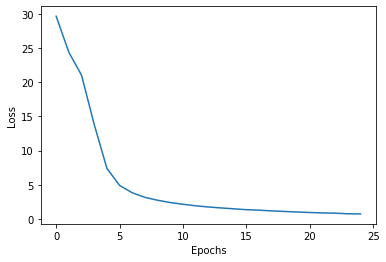

In [0]:
# LOADING THE MODEL
PATH='/content/drive/My Drive/Scene text recognition/text_recognition_revdecoder_epoch25.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
epoch = checkpoint['epoch']
loss_h=checkpoint['loss_h']

print("Model was saved at epoch:",epoch)
plt.plot(loss_h)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()